<a href="https://colab.research.google.com/github/shuen1106lu/Program-Language/blob/main/%E7%AC%AC%E5%85%AD%E5%91%A8%E7%B7%B4%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# 授權 Google Colab 存取 Google Sheets
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd

In [52]:
# 認證 Google Sheets API
creds, _ = default()
gc = gspread.authorize(creds)

# 讀取 Google Sheets（請換成你的試算表網址）
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/12MLiOu97Fv0jzbrSE5SMfYePBjwsKyBhax-j1paMMFY/edit?usp=sharing')

# 選擇第一個工作表
worksheet = gsheets.get_worksheet(0)


In [53]:
# 取得所有數據
data = worksheet.get_all_values()
df = pd.DataFrame(data[1:], columns=data[0])  # 第一行作為欄位名稱

# 去除可能的空格
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

<ipython-input-53-4aef1deb1674>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [54]:
# **從標題列篩選出真正的車站名稱**
valid_stations = []
for col in df.columns[3:]:  # 跳過前 3 欄
    if "混雜率" in col or "出發時間" in col:  # 遇到這些欄位就停止
        break
    valid_stations.append(col)

In [62]:
# 計算「每列車」的準時比率與早到比率（通過 = 準時）
def calc_rate_with_pass(row, status):
    total_stops = len(valid_stations)  # 限定只計算車站欄位
    matching_stops = ((row[valid_stations] == status) | (row[valid_stations] == "通過")).sum() if status == "準時" else (row[valid_stations] == status).sum()
    return matching_stops / total_stops if total_stops > 0 else 0  # 避免除以 0

df["準時比率"] = df.apply(lambda row: calc_rate_with_pass(row, "準時"), axis=1)
df["誤點比率"] = df.apply(lambda row: calc_rate_with_pass(row, "誤點"), axis=1)
df["早到比率"] = df.apply(lambda row: calc_rate_with_pass(row, "早到"), axis=1)

# 轉換為百分比格式（四捨五入到小數點後 2 位）
df["準時比率"] = (df["準時比率"] * 100).round(2).astype(str) + "%"
df["誤點比率"] = (df["誤點比率"] * 100).round(2).astype(str) + "%"
df["早到比率"] = (df["早到比率"] * 100).round(2).astype(str) + "%"

# 顯示結果（列車車次 + 準時比率 + 早到比率）
df_result = df[["列車車次","準時比率","誤點比率","早到比率"]]
# 取出「混雜率」和「出發時間」欄位（假設名稱為 '混雜率' 和 '出發時間'）
df_result.loc[:, "混雜率"] = df["混雜率"]
df_result.loc[:, "出發時間"] = df["出發時間"]

# 顯示結果，包含列車編號、準時比率、早到比率、混雜率和出發時間
print(df_result)

    列車車次    準時比率   誤點比率   早到比率   混雜率   出發時間
0  1431M   60.0%  30.0%  10.0%   75%   7:32
1  2015M   90.0%  10.0%   0.0%   82%  10:27
2  3951F   50.0%  30.0%  20.0%  101%  11:31
3  4177F   40.0%  40.0%  20.0%   79%  13:00
4  2027M  100.0%   0.0%   0.0%   85%  13:28
5  1247F   80.0%  10.0%  10.0%  121%  13:48
6  4213F   40.0%  40.0%  20.0%   94%  15:01
7  2047M   80.0%  20.0%   0.0%   99%  18:29


<ipython-input-62-24c7b40c3937>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result.loc[:, "混雜率"] = df["混雜率"]
<ipython-input-62-24c7b40c3937>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result.loc[:, "出發時間"] = df["出發時間"]


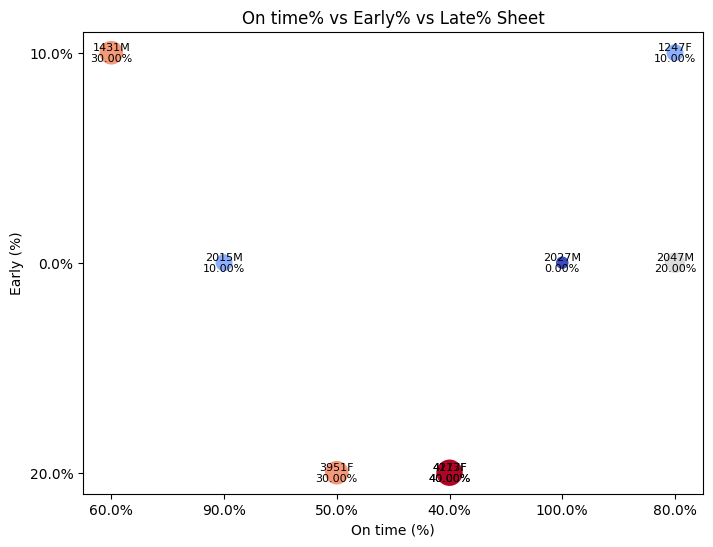

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 假設你已經有 df_result，並且包含了「準時比率」和「混雜率」這兩個參數

# 將數據按「準時比率」排序
df_sorted = df_result.sort_values(by="準時比率")
df_sorted = df_result.sort_values(by="早到比率")
df_sorted = df_result.sort_values(by="誤點比率")

# 繪製散佈圖，使用顏色來顯示誤點比率
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_result,
                x="準時比率",
                y="早到比率",
                hue="誤點比率",  # 根據誤點比率設定顏色
                palette="coolwarm",  # 顏色調色板，可以根據需求選擇
                size="誤點比率",  # 可以根據誤點比率調整點的大小，這是可選的
                sizes=(100, 400),  # 點的大小範圍
                legend=False)  # 是否顯示圖例（根據需要顯示）

# 標註每個點的列車編號
# 在每個點上標註列車編號和誤點比率
for idx, row in df_result.iterrows():
    train_id = row["列車車次"]  # 假設列車編號在這一列
    lateness_rate = row["誤點比率"]
    x = row["準時比率"]
    y = row["早到比率"]

    # 在點旁邊標註列車編號和誤點比率
    plt.text(x, y, f'{train_id}\n{lateness_rate:.2%}', fontsize=8, ha='center', va='center')


# 設定圖表標題和軸標籤
plt.title("On time% vs Early% vs Late% Sheet")
plt.xlabel("On time (%)")
plt.ylabel("Early (%)")
plt.show()